In [1]:
import pandas as pd
data = pd.read_csv("/kaggle/input/idvd-parameter/IDVD_WORKBOOK.csv")
data.head()

,width,height,length,tox1,tox2,Vd,Id
0,5,5,10,0.5,1.28,0.00,1.170000e-19
1,5,5,10,0.5,1.28,0.01,5.040000e-06
2,5,5,10,0.5,1.28,0.02,9.800000e-06
3,5,5,10,0.5,1.28,0.03,1.430000e-05
4,5,5,10,0.5,1.28,0.04,1.840000e-05


**Random Forest Regression on ID_VD**

Random Forest Regression Results:
Training Time: 10.2049 seconds
Testing Time: 0.5505 seconds
Computational Time: 10.7554 seconds
Number of Parameters (Nodes): 7924440
Estimated Energy Consumption: 7.924440 joules
R² Score: 0.9999
Energy Efficiency: 0.126176 R²/joule


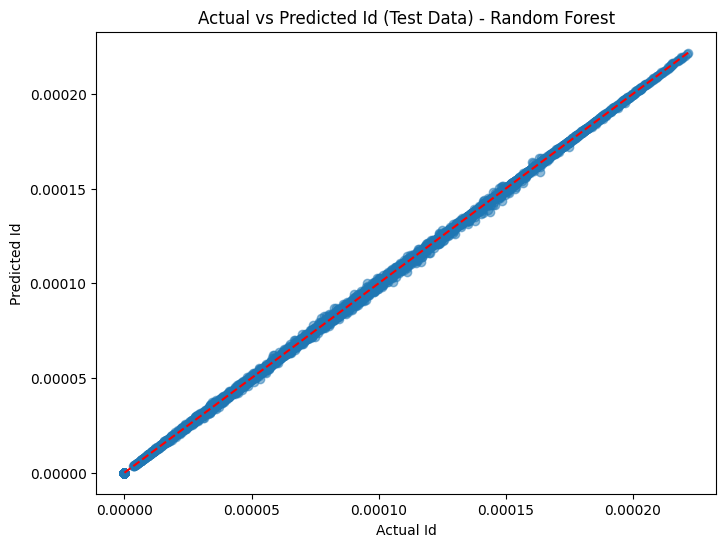

In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Features and target
X = data[['width', 'height', 'length', 'tox1', 'tox2','Vd']].values
y = data['Id'].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train and y_test to 2D arrays (for consistency)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Use StandardScaler for scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Initialize and train RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training time
start_time_rf = time.time()
rf_model.fit(X_train_scaled, y_train_scaled.ravel())  # Flatten y_train_scaled for compatibility
end_time_rf = time.time()
training_time_rf = end_time_rf - start_time_rf

# Testing time
start_test_time_rf = time.time()
y_pred_test_rf = rf_model.predict(X_test_scaled)
end_test_time_rf = time.time()
testing_time_rf = end_test_time_rf - start_test_time_rf

# Inverse scaling of predictions and actual values
y_pred_test_rf_rescaled = scaler_y.inverse_transform(y_pred_test_rf.reshape(-1, 1))
y_test_rescaled_rf = scaler_y.inverse_transform(y_test_scaled)

# Number of parameters (using node count as a proxy)
num_nodes_rf = sum(estimator.tree_.node_count for estimator in rf_model.estimators_)
num_params_rf = num_nodes_rf

# Estimate energy consumption (node count as proxy for complexity)
flops_rf = num_nodes_rf * 1e6  # assuming each node involves a large number of operations
estimated_energy_rf = flops_rf * 1e-12  # assuming 1 FLOP = 1 picoJoule (1e-12 J)

# Calculate R² score
r2_rf = r2_score(y_test_rescaled_rf, y_pred_test_rf_rescaled)

# Energy efficiency (R² score per joule)
energy_efficiency_rf = r2_rf / estimated_energy_rf

# Print results
print(f"Random Forest Regression Results:")
print(f"Training Time: {training_time_rf:.4f} seconds")
print(f"Testing Time: {testing_time_rf:.4f} seconds")
print(f"Computational Time: {testing_time_rf+training_time_rf:.4f} seconds")
print(f"Number of Parameters (Nodes): {num_params_rf}")
print(f"Estimated Energy Consumption: {estimated_energy_rf:.6f} joules")
print(f"R² Score: {r2_rf:.4f}")
print(f"Energy Efficiency: {energy_efficiency_rf:.6f} R²/joule")

# Scatter plot of actual vs predicted for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rescaled_rf, y_pred_test_rf_rescaled, alpha=0.5)
plt.plot([y_test_rescaled_rf.min(), y_test_rescaled_rf.max()],
         [y_test_rescaled_rf.min(), y_test_rescaled_rf.max()], 'r--')
plt.xlabel('Actual Id')
plt.ylabel('Predicted Id')
plt.title('Actual vs Predicted Id (Test Data) - Random Forest')
plt.show()

**Spiking Neural Networks(SNN) on ID_VD**

/opt/conda/lib/python3.10/site-packages/torch/utils/_cxx_pytree.py:242: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/opt/conda/lib/python3.10/site-packages/torch/utils/_cxx_pytree.py:242: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


Using GPU: Tesla P100-PCIE-16GB
Epoch 100/500 - Train Loss: 0.9972, Test Loss: 0.9800
Epoch 200/500 - Train Loss: 0.3696, Test Loss: 0.3580
Epoch 300/500 - Train Loss: 0.1559, Test Loss: 0.1440
Epoch 400/500 - Train Loss: 0.0605, Test Loss: 0.0399
Epoch 500/500 - Train Loss: 0.0371, Test Loss: 0.0236
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Training Time: 710.10 seconds
Testing Time: 0.0011649132 seconds
Number of Parameters: 135169
FLOPs: 134400.0
Estimated Energy Consumption: 0.000067 joules
R² Score: 0.9760
Energy Efficiency (R² per joule): 14523.943531 R² per joule


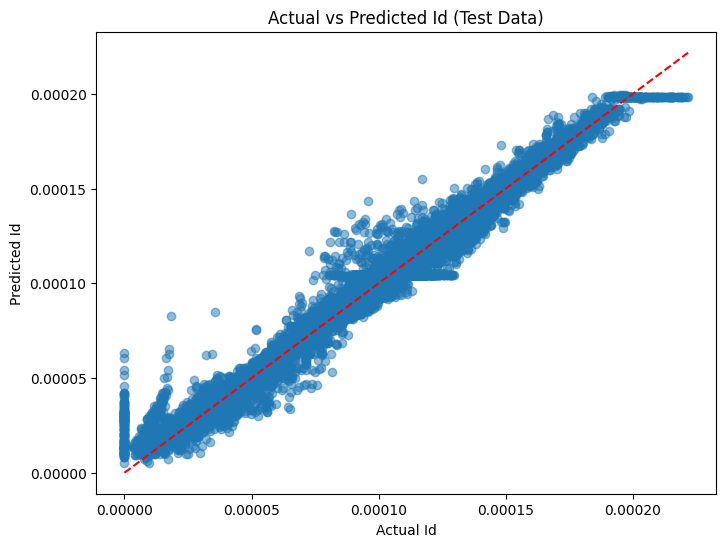

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import norse.torch as snn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import time
from thop import profile  # For FLOPs estimation


# Features and target
X = data[['width', 'height', 'length', 'tox1', 'tox2','Vd']].values
y = data['Id'].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train and y_test to 2D arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Use StandardScaler for scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Move tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Define SNN model using Norse
class SNNModel(nn.Module):
    def __init__(self, input_size):
        super(SNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.lif1 = snn.LIFCell()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 256)
        self.lif2 = snn.LIFCell()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.fc1(x)
        spk1, _ = self.lif1(x)
        spk1 = self.dropout1(spk1)

        x = self.fc2(spk1)
        spk2, _ = self.lif2(x)
        spk2 = self.dropout2(spk2)

        x = self.fc3(spk2)
        return x

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = SNNModel(input_size).to(device)  # Move model to GPU

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 500

# Training and Testing time tracking
train_losses = []
test_losses = []

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(X_train_tensor), shuffle=True)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(X_test_tensor), shuffle=False)

start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Ensure data is on GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Ensure data is on GPU
            test_outputs = model(inputs)
            test_loss = criterion(test_outputs, targets)
            running_test_loss += test_loss.item()

    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

end_time = time.time()
training_time_snn = end_time - start_time

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()  # Move to CPU for NumPy operations
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Inverse scaling of predictions and actual values
y_pred_train_rescaled = scaler_y.inverse_transform(y_pred_train)
y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
y_train_rescaled = scaler_y.inverse_transform(y_train_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate R² score
r2_snn = r2_score(y_test_rescaled, y_pred_test_rescaled)

# Calculate number of parameters
num_params_snn = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Estimate FLOPs (as a proxy for energy consumption)
input_tensor = torch.randn(1, input_size).to(device)  # Ensure input is on GPU
flops_snn, params = profile(model, inputs=(input_tensor,))

# Estimate energy consumption (very rough approximation)
# Assuming 1 FLOP consumes about 1 pJ (picojoule) of energy
estimated_energy_snn = flops_snn * 1e-12 * epochs  # Convert to joules
energy_efficiency_snn = r2_snn/estimated_energy_snn 

# Testing time
start_test_time = time.time()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
end_test_time = time.time()
testing_time_snn = end_test_time - start_test_time

# Print results
print(f"Training Time: {training_time_snn:.2f} seconds")
print(f"Testing Time: {testing_time_snn:.10f} seconds")
print(f"Number of Parameters: {num_params_snn}")
print(f"FLOPs: {flops_snn}")
print(f"Estimated Energy Consumption: {estimated_energy_snn:.6f} joules")
print(f"R² Score: {r2_snn:.4f}")
print(f"Energy Efficiency (R² per joule): {energy_efficiency_snn:.6f} R² per joule")

# Scatter plot of actual vs predicted for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rescaled, y_pred_test_rescaled, alpha=0.5)
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()], 
         [y_test_rescaled.min(), y_test_rescaled.max()], 'r--')
plt.xlabel('Actual Id')
plt.ylabel('Predicted Id')
plt.title('Actual vs Predicted Id (Test Data)')
plt.show()


**Convulution Neural Networks(CNN) on ID_VD**

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


I0000 00:00:1729477539.514478     286 service.cc:145] XLA service 0x7e6abc004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729477539.514534     286 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 100/1798 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3840

I0000 00:00:1729477544.806855     286 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1798/1798 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0897 - val_loss: 0.0076
Epoch 2/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0170 - val_loss: 0.0054
Epoch 3/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0133 - val_loss: 0.0051
Epoch 4/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0117 - val_loss: 0.0072
Epoch 5/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0109 - val_loss: 0.0045
Epoch 6/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 7/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0102 - val_loss: 0.0024
Epoch 8/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092 - val_loss: 0.0025
Epoch 9/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092 - val_loss: 0.0031
Epoch 10/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0085 - val_loss: 0.0030
Epoch 11/100
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 12/100
1798/1798 ━━━━━━━

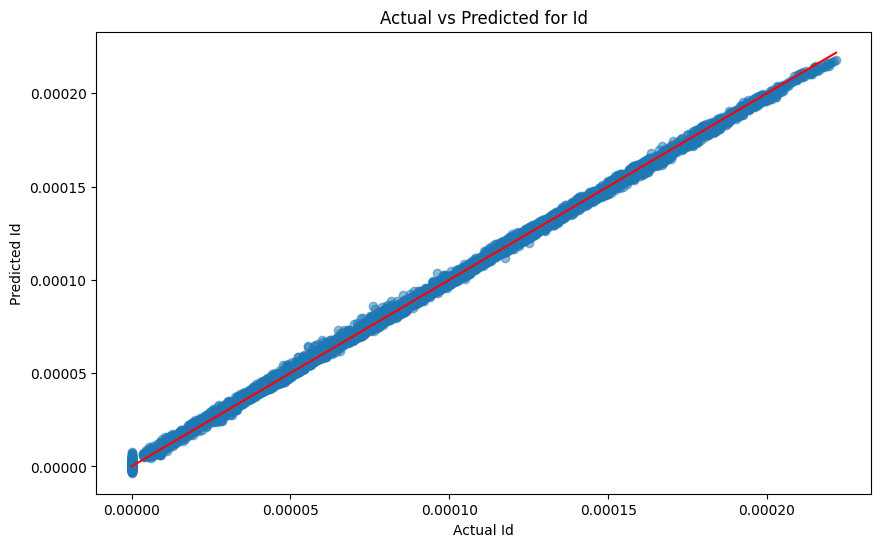

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import numpy as np
import time
from thop import profile
import torch
import torch.nn as nn

# Assuming 'data' is your DataFrame containing the dataset
# Separate input features and output features
X = data[['width', 'height', 'length', 'tox1', 'tox2','Vd']]
y = data[['Id']]

# Reshape input features for Conv1D (samples, timesteps, features)
X = X.values.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-2])).reshape(X_test.shape)

# Scale the target variables
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

# Build the CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer="adam", loss='mean_squared_error')

# Move the model to GPU if available
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
with tf.device(device):
    # Training the model on GPU
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    end_time = time.time()
    training_time_cnn = end_time - start_time

    # Testing the model on GPU
    start_test_time = time.time()
    y_pred = model.predict(X_test)
    end_test_time = time.time()
    testing_time_cnn = end_test_time - start_test_time

# PyTorch Model for FLOPs calculation (now on GPU)
class TorchModel(nn.Module):
    def __init__(self, input_length):
        super(TorchModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=2)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128 * (input_length - 2), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Move the PyTorch model and inputs to GPU if available
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_model = TorchModel(input_length=X_train.shape[1]).to(torch_device)

# Calculate FLOPs
input_tensor = torch.randn(1, 1, X_train.shape[1]).to(torch_device)
flops, _ = profile(torch_model, inputs=(input_tensor,))
flops_per_sample = flops * 2  # Accounting for forward and backward pass

# Computational time
computational_time_cnn = training_time_cnn + testing_time_cnn

# Calculate total FLOPs and estimated energy consumption
total_flops = flops_per_sample * len(X_train) * 100  # 100 epochs
estimated_energy_cnn = total_flops * 1e-12  # Assuming 1 FLOP = 1 pJ (picojoule)

# Inverse transform the predictions and the test target variables
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)

# Calculate R² score
r2_cnn = r2_score(y_test, y_pred)

# Calculate energy efficiency
energy_efficiency_cnn = r2_cnn / estimated_energy_cnn
params_cnn = model.count_params()

# Print results
print(f"Training Time: {training_time_cnn:.4f} seconds")
print(f"Testing Time: {testing_time_cnn:.4f} seconds")
print(f"Computational Time: {computational_time_cnn:.4f} seconds")
print(f"Number of Parameters: {params_cnn}")
print(f"FLOPs per sample (forward + backward): {flops_per_sample}")
print(f"Total FLOPs: {total_flops}")
print(f"Estimated Energy Consumption: {estimated_energy_cnn:.6f} joules")
print(f"R² Score: {r2_cnn:.4f}")
print(f"Energy Efficiency (R² per joule): {energy_efficiency_cnn:.6f}")

# Plot actual vs predicted for SS
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('Actual Id')
plt.ylabel('Predicted Id')
plt.title('Actual vs Predicted for Id')
plt.show()


**Comparing Metrics**

In [10]:
# Print the header for the comparison table
print(f"{'Metric':<30} | {'Random Forest Regression':<30} | {'Spiking Neural Network':<30} | {'Convolutional Neural Network':<30}")
print("-" * 127)

# Print the results for each model side by side
print(f"{'Training Time (s)':<30} | {training_time_rf:<30.4f} | {training_time_snn:<30.4f} | {training_time_cnn:<30.4f}")
print(f"{'Testing Time (s)':<30} | {testing_time_rf:<30.4f} | {testing_time_snn:<30.4f} | {testing_time_cnn:<30.4f}")
print(f"{'Computational Time (s)':<30} | {training_time_rf + testing_time_rf:<30.4f} | {training_time_snn + testing_time_snn:<30.4f} | {computational_time_cnn:<30.4f}")
print(f"{'Number of Parameters':<30} | {num_params_rf:<30} | {num_params_snn:<30} | {params_cnn:<30}")
print(f"{'FLOPs per sample':<30} | {'N/A':<30} | {flops_snn:<30} | {flops_per_sample:<30}")
print(f"{'Total FLOPs':<30} | {'N/A':<30} | {'N/A':<30} | {total_flops:<30}")
print(f"{'Energy Consumption (J)':<30} | {estimated_energy_rf:<30.6f} | {estimated_energy_snn:<30.6f} | {estimated_energy_cnn:<30.6f}")
print(f"{'R² Score':<30} | {r2_rf:<30.4f} | {r2_snn:<30.4f} | {r2_cnn:<30.4f}")
print(f"{'Energy Efficiency (R²/joule)':<30} | {energy_efficiency_rf:<30.6f} | {energy_efficiency_snn:<30.6f} | {energy_efficiency_cnn:<30.6f}")

# Print a separator line
print("-" * 127)

Metric                         | Random Forest Regression       | Spiking Neural Network         | Convolutional Neural Network  
-------------------------------------------------------------------------------------------------------------------------------
Training Time (s)              | 10.2049                        | 1464.7838                      | 341.4779                      
Testing Time (s)               | 0.5505                         | 0.0012                         | 1.4042                        
Computational Time (s)         | 10.7554                        | 1464.7849                      | 342.8820                      
Number of Parameters           | 7924440                        | 135169                         | 99073                         
FLOPs per sample               | N/A                            | 134400.0                       | 396032.0                      
Total FLOPs                    | N/A                            | N/A                       

**Final Comparision**

In [11]:
# Create a formatted table for comparison
print("\n===== Model Comparison Table =====")
print(f"{'Model':<30}{'Energy Efficiency (R²/joule)':<30}{'Difference Compared to Best (%)':<40}")
print("="*100)

# Determine the model with the highest energy efficiency
efficiencies = {
    "Random Forest Regression": energy_efficiency_rf,
    "Spiking Neural Network": energy_efficiency_snn,
    "Convolutional Neural Network": energy_efficiency_cnn
}

best_model = max(efficiencies, key=efficiencies.get)
best_efficiency = efficiencies[best_model]

# Calculate and print the percentage difference for each model, including the best model (0% difference)
for model_name, efficiency in efficiencies.items():
    if model_name == best_model:
        diff_percentage = 0.0
    else:
        diff_percentage = ((best_efficiency - efficiency) / efficiency) * 100
    
    print(f"{model_name:<30}{efficiency:<30.6f}{diff_percentage:<40.2f}")

# Print the line separator
print("="*100)

# Final conclusion
print(f"\nThe {best_model} model has the highest energy efficiency of {best_efficiency:.6f} R²/joule.")


===== Model Comparison Table =====
Model                         Energy Efficiency (R²/joule)  Difference Compared to Best (%)         
Random Forest Regression      0.126176                      5838163.08                              
Spiking Neural Network        7366.463956                   0.00                                    
Convolutional Neural Network  0.350782                      2099911.39                              

The Spiking Neural Network model has the highest energy efficiency of 7366.463956 R²/joule.
